In [8]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

import html
import urllib

from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

# Functions

In [2]:
def normalize(data, column_name):
    ''' Normalize a column in a dataframe '''
    return (data[column_name] - data[column_name].mean())/data[column_name].std()

def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

# Reading data

In [3]:
graphs_path = './data/wikispeedia_paths-and-graph/'

link_network_pos = pd.read_pickle('link_network_w_position.df')
finished_paths = pd.read_pickle('finished_paths_w_positions.df')
unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

### Data preparation

In [4]:
# Binary indicator of whether a player completed a path (1) or not (0):
paths = pd.concat([finished_paths, unfinished_paths])
paths['completion'] = [1]*len(finished_paths) + [0]*len(unfinished_paths)

In [5]:
# Standardize the countinuous features
paths_normalized = paths.copy()
paths_normalized['avg_article_length'] = normalize(paths, 'avg_article_length')
paths_normalized['avg_position'] = normalize(paths, 'avg_position')
paths_normalized['avg_target_source_ratio'] = normalize(paths, 'avg_target_source_ratio')

# Drop NaN in features columns
paths_normalized = paths_normalized.dropna(subset=['avg_article_length', 'avg_position', \
                                                   'avg_target_source_ratio'])

# MODEL 1: Logistic regression with `completion`

In [6]:
# Model 1 
mod = smf.logit(formula = 'completion ~ avg_article_length + avg_position + avg_target_source_ratio',
                data = paths_normalized)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.565335
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             completion   No. Observations:                56710
Model:                          Logit   Df Residuals:                    56706
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                0.002341
Time:                        11:56:10   Log-Likelihood:                -32060.
converged:                       True   LL-Null:                       -32135.
Covariance Type:            nonrobust   LLR p-value:                 2.127e-32
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0873      0.010    111.560      0.000       1.068   

### Visualization of the results

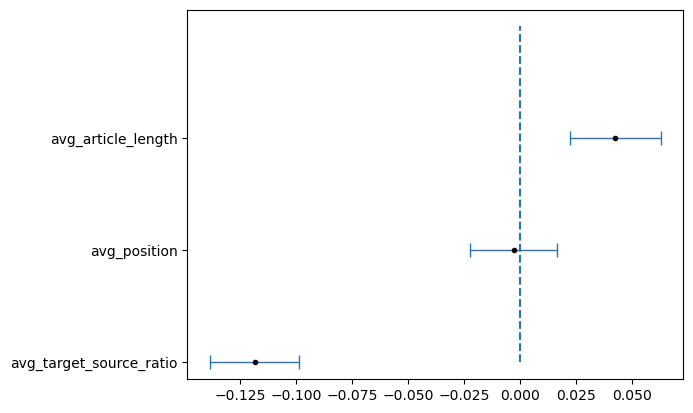

In [7]:
# Contribution of each features
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

### Evaluation of the model

In [11]:
# Features vector
X = paths_normalized[['avg_article_length', 'avg_position', 'avg_target_source_ratio']]
# Label
y = paths_normalized['completion']

# Train the model and compute metrics
logistic = LogisticRegression(solver='lbfgs')
precision = cross_val_score(logistic, X, y, cv=10, scoring="precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring="recall")
accuracy = cross_val_score(logistic, X, y, cv=10, scoring="accuracy")
f1_score = cross_val_score(logistic, X, y, cv=10, scoring="f1")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1-score: %0.2f (+/- %0.2f)" % (f1_score.mean(), f1_score.std() * 2))

Precision: 0.75 (+/- 0.00)
Recall: 1.00 (+/- 0.00)
Accuracy: 0.75 (+/- 0.00)
F1-score: 0.85 (+/- 0.00)


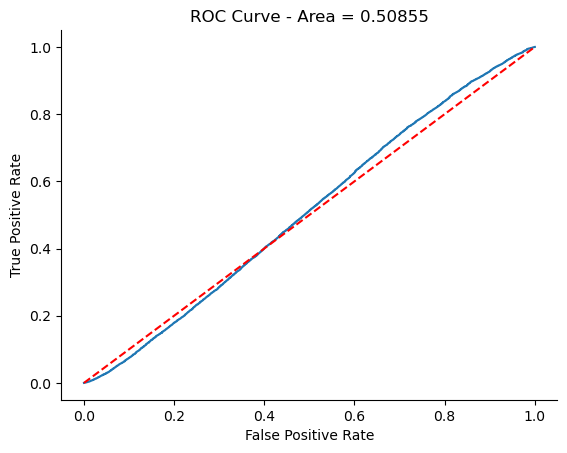

In [14]:
# ROC Curve
logistic = LogisticRegression(solver='lbfgs')
y_pred = cross_val_predict(logistic, X, y, cv=10, method="predict_proba")
fpr, tpr, _ = roc_curve(y, y_pred[:, 1]) #False Positive Rate and True Positive Rate
auc_score = auc(fpr, tpr) # Area under the curve

fig, ax = plt.subplots()

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve - Area = {:.5f}".format(auc_score));
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Discussion

The logistic regression has a very low R-Squared of 0.002341. This means that this model does not really explain the variance of the `completion` variable. The ROC Curve complete this observation: it is almost a straight line, so our model is almost like a random one. Therefore, the fact that a player completes or not a path does not seems to be linked to the architecture of the wikipedia articles browsed.

# MODEL 2: Linear regression with `avg_duration`

In [15]:
mod = smf.ols(formula='avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
              data=paths_normalized)
res = mod.fit()
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:           avg_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.25
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           7.81e-12
Time:                        12:03:47   Log-Likelihood:            -3.7537e+05
No. Observations:               56710   AIC:                         7.508e+05
Df Residuals:                   56706   BIC:                         7.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

### Visualization of the results

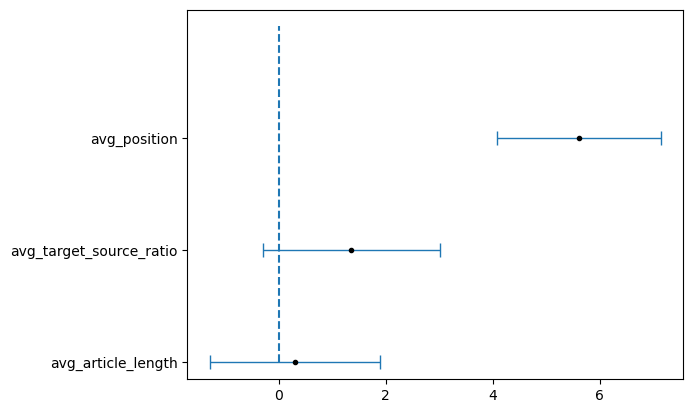

In [16]:
# Contribution of each features
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

### Test the normality of the residuals

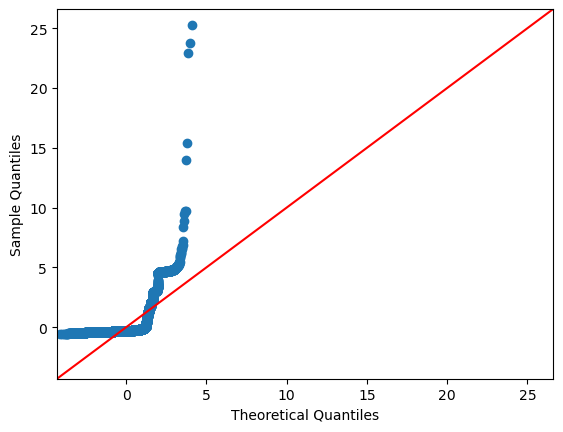

In [18]:
fig = sm.graphics.qqplot(res.resid, dist=norm, line='45', fit=True)

### Discussion

This model has a very low R-squared of 0.001. The variance of the `avg_duration` spend per article during a path is not explained by a linear relationship between the features of the articles. Looking at the normality of the residualds, this assumption of linear regression is clearly not respected. Therefore, a log-transformation is applied before running again the model. 

# MODEL 2: Linear regression with `log_avg_duration`

In [19]:
paths_normalized['log_avg_duration'] = np.log(paths_normalized['avg_duration'])

In [20]:
mod = smf.ols(formula='log_avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
              data=paths_normalized)
res = mod.fit()
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:       log_avg_duration   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     400.6
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          1.58e-257
Time:                        12:06:03   Log-Likelihood:                -90248.
No. Observations:               56710   AIC:                         1.805e+05
Df Residuals:                   56706   BIC:                         1.805e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

### Visualization of the results

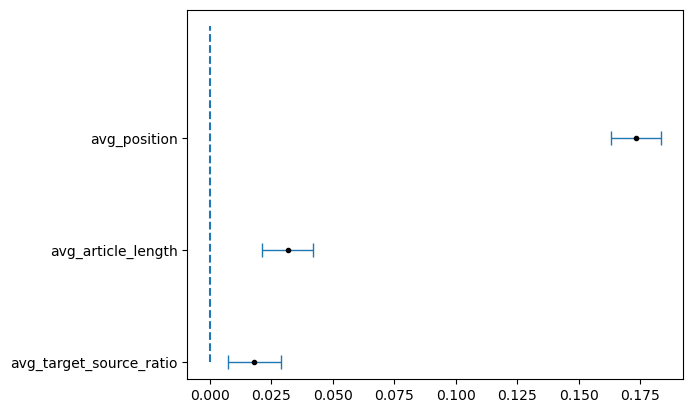

In [21]:
# Contribution of each features
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

### Test the normality of the residuals

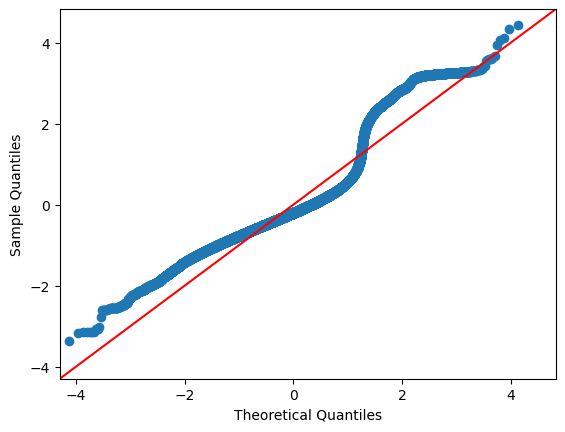

In [23]:
fig = sm.graphics.qqplot(res.resid, dist=norm, line='45', fit=True)

### Evaluation of the model

In [24]:
# Features vector
X = paths_normalized[['avg_article_length', 'avg_position', 'avg_target_source_ratio']]

# Label
y = paths_normalized['log_avg_duration']
y.replace(-np.inf, y.min(), inplace=True) #replace -inf value by the minimum value


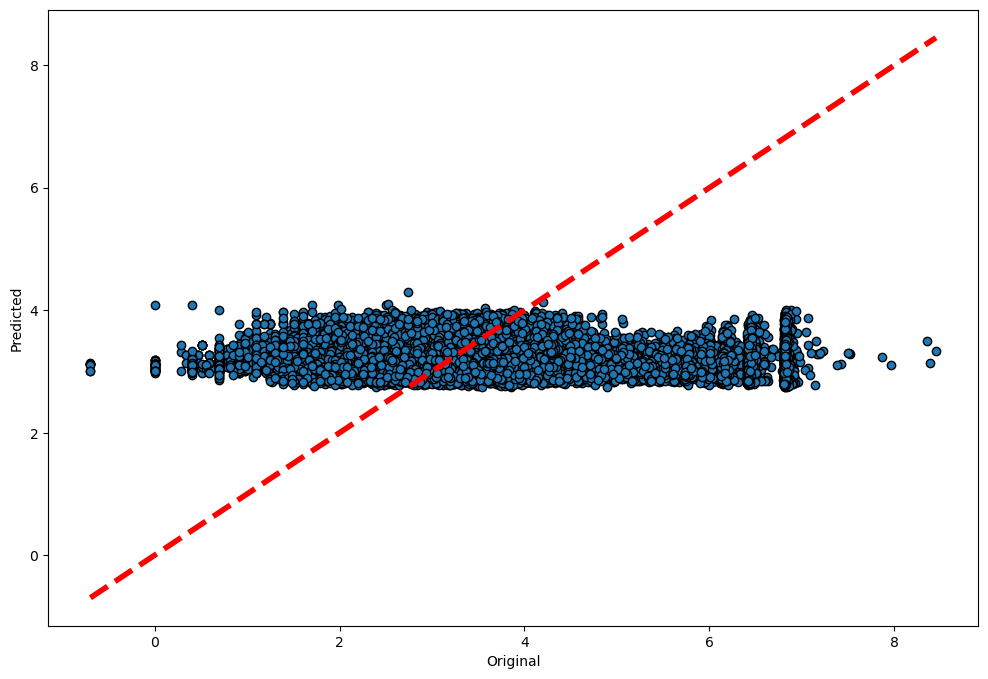

In [25]:
# Train the model
linear = LinearRegression()
predicted = cross_val_predict(linear, X, y, cv=10)

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

### Discussion

The R-squared of the model using the log transformation of the dependent variable actually increased compare to the first version of the regression: it is now 0.021. It is still very low and does not allow to explain the variance of the `avg_duration` variable. The normality of the residuals is also improved. However, looking at the graph of the original values against the predicted one, the model does not seems to predict very well the average duration spend per article for a player. 